# Import

In [48]:
# !nvidia-smi

In [51]:
import os
import sys
from multiprocessing import Pool
from collections import OrderedDict
from time import time
import datetime
from importlib import reload

import pandas as pd
import numpy as np
import random

import torch 
from torch import nn
from torch.utils.data import dataloader
from transformers import AutoTokenizer, BertModel

##
import data_processing
from models import models_based_on_pretrain
from utils import *
import train_processing


device = torch.device('cpu') # 'cpu' 'cuda:0' 
print(device)

%matplotlib inline

cpu


## reload

In [69]:
reload(data_processing)
reload(train_processing)
reload(models_based_on_pretrain)

<module 'models.models_based_on_pretrain' from '/Users/shenjia/Desktop/google_cloud/text_representation/models/models_based_on_pretrain.py'>

# Pretrain Models

In [3]:
"""
path
"""
tokenizer_path = '../nlp_resource/transformers/bert-base-chinese/' # tokenizer
bert_path = '../nlp_resource/transformers/bert-base-chinese/' # bert

"""
get pretrain model
"""
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
bert = BertModel.from_pretrained(bert_path).to(device)
bert.training

Some weights of the model checkpoint at ../nlp_resource/transformers/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


False

# Dataset

In [4]:
data_processor = data_processing.DataProcessor()
data_processor.set_vocab(tokenizer.vocab)
data_processor.vocab is tokenizer.vocab # should be False

False

## atec

In [5]:
"""
读取
"""
atec = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../nlp_resource/dataset/ATEC/atec_nlp_sim_train.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)

atec_add = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../nlp_resource/dataset/ATEC/atec_nlp_sim_train_add.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)
atec = atec + atec_add

------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 39346
['怎么更改花呗手机号码', '我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号', '1']
['也开不了花呗，就这样了？完事了', '真的嘛？就是花呗付款', '0']
['花呗冻结以后还能开通吗', '我的条件可以开通花呗借款吗', '0']
['如何得知关闭借呗', '想永久关闭借呗', '0']
['花呗扫码付钱', '二维码扫描可以用花呗吗', '0']
[read_data] cost 0.07s
------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 63131
['为何我无法申请开通花呗信用卡收款', '支付宝开通信用卡花呗收款不符合条件怎么回事', '1']
['花呗分期付款会影响使用吗', '花呗分期有什么影响吗', '0']
['为什么我花呗没有临时额度', '花呗没有临时额度怎么可以负', '0']
['能不能开花呗老兄', '花呗逾期了还能开通', '0']
['我的怎么开通花呗收钱', '这个花呗是个什么啥？我没开通 我怎么有账单', '0']
[read_data] cost 0.10s


In [6]:
"""
预处理
"""
# 单进程处理
# atec = data_processor.preprocess_similarity_data(atec)


# 多进程处理
work_num = 10
func = data_processor.preprocess_similarity_data
atec = data_processor.multi(work_num, func,atec)

Process:0 | [0:10247] 
Process:1 | [10247:20494] 
Process:2 | [20494:30741] 
Process:3 | [30741:40988] 
Process:4 | [40988:51235] 
Process:5 | [51235:61482] 
Process:6 | [61482:71729] 
Process:7 | [71729:81976] 
Process:8 | [81976:92223] 
Process:9 | [92223:102477] 
[multi] cost 1.78s


## bq_corpus

In [7]:
"""
读取
"""
path= './data/bq_corpus/'
mode = 'pandas'
sep = ','
encoder = 'utf-8'

bq_corpus_train = data_processor.read_data(mode=mode,sep=sep,encoder=encoder,
                                           name='bq_corpus_train', 
                                           path=path+'train.csv')

bq_corpus_val = data_processor.read_data(mode=mode,sep=sep,encoder=encoder,
                                         name='bq_corpus_val', 
                                         path=path+'dev.csv')

bq_corpus_test = data_processor.read_data(mode=mode,sep=sep,encoder=encoder,
                                          name='bq_corpus_test', 
                                          path=path+'test.csv')

------------------------------------------
start to read: [bq_corpus_train]...
finish reading: [bq_corpus_train]
nums: 100000
['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0]
['微信消费算吗', '还有多少钱没还', 0]
['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0]
['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0]
['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0]
[read_data] cost 0.18s
------------------------------------------
start to read: [bq_corpus_val]...
finish reading: [bq_corpus_val]
nums: 10000
['不要借了我是试试看能否操作的', '借款审核期间能否取消借款', 0]
['亲怎样才能在钱包里有微粒货的图标呢', '借不到', 0]
['你好，我还款银行怎么更换', '怎么更换绑定还款的卡', 1]
['我的借贷额度，怎么减少了呢？', '微粒贷额度怎么才能降低', 0]
['什么时候可以知道借款成功', '2.多笔借款', 0]
[read_data] cost 0.01s
------------------------------------------
start to read: [bq_corpus_test]...
finish reading: [bq_corpus_test]
nums: 10000
['为什么我无法看到额度', '为什么开通了却没有额度', 0]
['为啥换不了', '为两次还都提示失败呢', 0]
['借了钱，但还没有通过，可以取消吗？', '可否取消', 1]
['为什么我申请额度输入密码就一直是那个页面', '为什么要输入支付密码来验证', 0]
['今天借 明天还款可以？', '今天借明天还要手续费吗', 0]
[read_data] cost 0.01s


In [8]:
"""
预处理

test 数据集也可以处理, 不过只使用训练集的经验知识来处理
"""
# 单进程处理
# bq_corpus_train = data_processor.preprocess_similarity_data(bq_corpus_train)
# bq_corpus_val = data_processor.preprocess_similarity_data(bq_corpus_val)
# bq_corpus_test = data_processor.preprocess_similarity_data(bq_corpus_test)

# 多进程处理
work_num = 10
func = data_processor.preprocess_similarity_data
bq_corpus_train = data_processor.multi(work_num, func, bq_corpus_train)
bq_corpus_val = data_processor.multi(work_num, func, bq_corpus_val)
bq_corpus_test = data_processor.multi(work_num, func, bq_corpus_test)

Process:0 | [0:10000] 
Process:1 | [10000:20000] 
Process:2 | [20000:30000] 
Process:3 | [30000:40000] 
Process:4 | [40000:50000] 
Process:5 | [50000:60000] 
Process:6 | [60000:70000] 
Process:7 | [70000:80000] 
Process:8 | [80000:90000] 
Process:9 | [90000:100000] 
[multi] cost 1.84s
Process:0 | [0:1000] 
Process:1 | [1000:2000] 
Process:2 | [2000:3000] 
Process:3 | [3000:4000] 
Process:4 | [4000:5000] 
Process:5 | [5000:6000] 
Process:6 | [6000:7000] 
Process:7 | [7000:8000] 
Process:8 | [8000:9000] 
Process:9 | [9000:10000] 
[multi] cost 0.27s
伸请微粒货我到疷要等多久帮忙查下   | 30135(･ิϖ･ิ)っ看不到 || 3636疷为什么我没有微鞡货 我借不了款 
 || 如何还歀ิ 为什么我没有微鞡货 我借不了款 
 38817| (･ิϖ･ิ)っ看不到 | |27456 |  38817 鞡强烈要求增额﹉如何还歀 |982
 |   || 为什么我没有微鞡货 我借不了款歀|  鞡 为什么我没有微鞡货 我借不了款 
6509727456
|ϖ   |
 为什么我没有微鞡货 我借不了款|| (･ิϖ･ิ)っ看不到38817    38817 |﹉歀| | 伸请微粒货我到疷要等多久帮忙查下

 38817|   鞡3636 为什么我没有微鞡货 我借不了款|| 
如何还歀鞡 | 
 30135 鞡| ิ
 | 
27456 疷 
|(･ิϖ･ิ)っ看不到  |歀|
  363638817  Process:0 | [0:1000] 
Process:1 | [1000:2000] 
Process:2 | [2000:30

## build dataset

### Similarity Dataset

#### single

In [ ]:
train = bq_corpus_train
val = bq_corpus_val
test = bq_corpus_test

len(train), len(val), len(test)

#### sum

In [24]:
train = bq_corpus_train + atec
val = bq_corpus_val
test = bq_corpus_test

len(train), len(val), len(test)

(202477, 10000, 10000)

#### sum + exchange

In [25]:
train = bq_corpus_train + atec
q1, q2, label = tuple(zip(*train))
train_change = list(zip(q2,q1,label))

train = train + train_change
val = bq_corpus_val
test = bq_corpus_test

len(train), len(val), len(test)

(404954, 10000, 10000)

#### description

最大长度: 201


<AxesSubplot:>

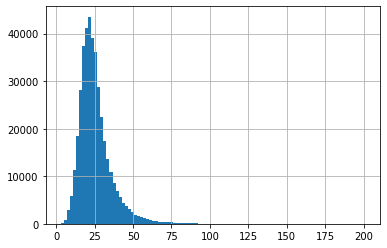

In [26]:
q1, q2, label = list(zip(*train))
q = [q1[i]+q2[i] for i in range(len(label))]

res = pd.Series(q).apply(lambda x: len(x))
print('最大长度:',res.max())
res.hist(bins=100)

### mlm dataset

In [9]:
"""
ori text data
"""
mlm_data = (list(zip(*bq_corpus_train))[0] 
            + list(zip(*bq_corpus_train))[1]
            + list(zip(*bq_corpus_val))[0]
            + list(zip(*bq_corpus_val))[1]
            + list(zip(*atec))[0]
            + list(zip(*atec))[1])
len(mlm_data)

424954

In [10]:
"""
drop duplicate
"""
mlm_data = list(set(mlm_data))
print(len(mlm_data))
for i in range(5):
    print(mlm_data[i])

227826
买车可以用花呗吗
我的花呗收不了款是什么原因
花呗账号和现在的账号不一样怎么办
花呗最低还款，只还一半可以吗
使用花呗后有抽一次奖的，是否没了


<AxesSubplot:>

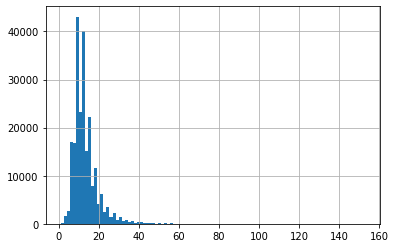

In [11]:
pd.Series(mlm_data).apply(lambda x : len(x)).hist(bins=100)

In [12]:
"""
split data idx
"""
val_idx = random.sample(range(len(mlm_data)), int(1e4))
val_hash_idx = {}
for i in val_idx:
    val_hash_idx[i]=0

In [13]:
"""
get split data
"""
val = [mlm_data[i] for i in range(len(mlm_data)) if i in val_hash_idx]
train = [mlm_data[i] for i in range(len(mlm_data)) if i not in val_hash_idx]
print(len(mlm_data),len(val), len(train))

227826 10000 217826


In [14]:
"""
mask data
"""
train = data_processor.get_masked_data(train) + data_processor.get_masked_data(train) # mask 两次
val = data_processor.get_masked_data(val)

Inputs & labels:
[['买', '车', '可', '以', '用', '花', '呗', '吗'], ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '用', '[PAD]', '[PAD]', '[PAD]']]
[['我', '的', '花', '呗', '收', '不', '了', '么', '是', '[MASK]', '么', '原', '因'], ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '款', '[PAD]', '什', '[PAD]', '[PAD]', '[PAD]']]
[['花', '[MASK]', '账', '号', '和', '现', '在', '的', '账', '号', '不', '一', '样', '怎', '么', '办'], ['[PAD]', '呗', '[PAD]', '[PAD]', '和', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']]
[['花', '呗', '[MASK]', '低', '还', '款', '，', '只', '还', '一', '半', '可', '以', '[MASK]'], ['[PAD]', '[PAD]', '最', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '吗']]
[['使', '了', '花', '呗', '后', '有', '抽', '[MASK]', '次', '奖', '的', '，', '是', '否', '没', '了'], ['[PAD]', '用', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '一', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']]
Inputs & labels:
[['买', '车', '可

In [15]:
len(train), len(val)

(435652, 10000)

## dataloader

In [16]:
def collate_list_of_list(x):
    """
    针对已经分离好了的 list 样本
    [
        [ ['我','[MASK]','你'], ['[PAD]','看','[PAD]'] ],
        [ [...], [...] ],
        ...
    ]
    输入为根据 idx 挑出来的一个batch
    """
    inputs = []
    labels = []
    for i in x:
        inputs.append(i[0])
        labels.append(i[1])
    return inputs,labels

In [17]:
dataloader_config = {
    'collate_fn': collate_list_of_list,
    'batch_size': 32
}

In [18]:
train_loader = data_processor.create_dataloader(train, is_shuffle=True, **dataloader_config)
val_loader = data_processor.create_dataloader(val, is_shuffle=True, **dataloader_config)
if 'test' in locals():
    test_loader = data_processor.create_dataloader(test, is_shuffle=False, **dataloader_config)

# 查验是否能迭代起来
for i in train_loader:  
    break

# Model

In [19]:
model_config = {
    'name': 'mlm_bert',
    'device': device,
    'tokenizer': tokenizer,
    'pretrain_model': bert,
    
    'max_len': 120
}

In [20]:
model = MlmBert(**model_config)
model.save(prefix='init')

# training

In [34]:
loss = nn.CrossEntropyLoss(reduction='none') # 注意得到的loss还要去mask，所以不能提前mean
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [70]:
trainer = train_processing.Trainer(train_loader, val_loader, model, loss, optimizer)

In [71]:
trainer.training()

start training: 2021-09-28 21:14:59.240454
------------------------------------------
Epoch: 1


KeyboardInterrupt: 